<a href="https://colab.research.google.com/github/Anushkajoshi000/openVINOImageClassification-/blob/main/OpenVino_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!source /opt/intel/openvino/bin/setupvars.sh

/bin/bash: line 1: /opt/intel/openvino/bin/setupvars.sh: No such file or directory


In [10]:
!pip install openvino

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 20.7 MB/s eta 0:00:00


In [12]:
!pip install -q "openvino-dev>=2023.0.0" "numpy>=1.21.0" "opencv-python" "matplotlib>=3.6.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.3 MB/s eta 0:00:00


In [13]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from openvino.runtime import Core, serialize
from openvino.tools import mo

In [14]:
# The paths of the source and converted models.
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

model_path = Path("model/v3-small_224_1.0_float")

ir_path = Path("model/v3-small_224_1.0_float.xml")

In [15]:
model = tf.keras.applications.MobileNetV3Small()
model.save(model_path)

10734624/10734624 [==============================] - 0s 0us/step


In [16]:
# Run model conversion API if the IR model file does not exist
if not ir_path.exists():
    print("Exporting TensorFlow model to IR... This may take a few minutes.")
    ov_model = mo.convert_model(saved_model_dir=model_path, input_shape=[[1, 224, 224, 3]], compress_to_fp16=True)
    serialize(ov_model, ir_path)
else:
    print(f"IR model {ir_path} already exists.")

Exporting TensorFlow model to IR... This may take a few minutes.


In [17]:

core = Core()
model = core.read_model(ir_path)

In [18]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [19]:
compiled_model = core.compile_model(model=model, device_name=device.value)

In [20]:
input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
network_input_shape = input_key.shape

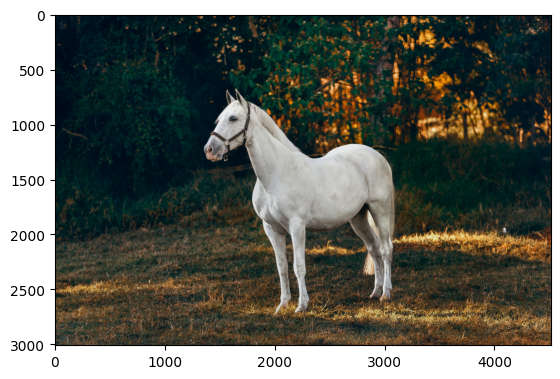

In [22]:
# The MobileNet network expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename="/content/horse.jpg"), code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape.
resized_image = cv2.resize(src=image, dsize=(224, 224))

# Transpose the image to the network input shape.
input_image = np.expand_dims(resized_image, 0)

plt.imshow(image);

In [23]:
result = compiled_model(input_image)[output_key]

result_index = np.argmax(result)

In [26]:
# Convert the inference result to a class name.
imagenet_classes = open("./imagenet_2012.txt").read().splitlines()

imagenet_classes[result_index]

'n02113799 standard poodle'

In [27]:
num_images = 1000

start = time.perf_counter()

for _ in range(num_images):
    compiled_model([input_image])

end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

IR model in OpenVINO Runtime/CPU: 0.0041 seconds per image, FPS: 245.98
